---
**Module 1 Final Project Submission**

* Student name: **Ru Keïn**
* Student pace: **Full-Time**
* Project review date/time: **November 1, 2019 at 10:00 AM PST**
* Instructor name: **James Irving, PhD**
* Blog post URL: www.hakkeray.com/datascience/projects/king-county-housing-data

---
# Obtain
* Import requisite libraries and data
* Inspect columns, dataypes
    * df.head()

In [1]:
# import PyPi package for cohort libraries using shortcut
#!pip install -U fsds_100719 # comment out after install so it won't run again

In [1]:
import fsds_100719 as fs
from fsds_100719.imports import *
plt.style.use('seaborn')
#inline_rc = dict(mpl.rcParams)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import normaltest as normtest # D'Agostino and Pearson's omnibus test
from collections import Counter
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

fsds_1007219  v0.4.8 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 
> For convenient loading of standard modules use: `>> from fsds_100719.imports import *`



Package,Handle,Description
IPython.display,dp,Display modules with helpful display and clearing commands.
fsds_100719,fs,Custom data science bootcamp student package
matplotlib,mpl,Matplotlib's base OOP module with formatting artists
matplotlib.pyplot,plt,Matplotlib's matlab-like plotting module
numpy,np,scientific computing with Python
pandas,pd,High performance data structures and tools
seaborn,sns,High-level data visualization library based on matplotlib


In [2]:
#ignore pink warnings
import warnings
warnings.filterwarnings('ignore')

# Allow for large # columns
pd.set_option('display.max_columns', 0)
# pd.set_option('display.max_rows','')

In [252]:
# import dataset and review data types, columns, values
df = pd.read_csv('kc_house_data.csv') 
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


---
# SCRUB 

## Re-Casting and Hot-Coding

**Q1: Which predictors should be analyzed as continuous data, vs binned/categorical data?**

+ preliminary analysis, data casting, and visualizations
+ check for linearity, normal distributions

       * Check and cast data types
               * df.info()
               * df.set_index()
               * df.unique()
               * df.isna().sum()
               * df.describe()
               * df.min(), .max()
               * df.value_counts()
          

In [253]:
# Display information about the variables, columns and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


**FIRST GLANCE - Items to note**
* There are 2 object datatypes that contain numeric values : 'date', 'sqft_basement'
* The total value count is 21597. Some columns appear to be missing a substantial amount of data (waterfront and yr_renovated).

In [254]:
# Let's take a quick look at the statistical data:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Before jumping head-first into the data-munging process, a little house-keeping will help us approach the data more methodically. Let's break the columns up into groups based on features as they relate to a real estate market context:

TARGET
**price**
* range: 78,000 to 7,700,000
* mean value: 540,296
* median value: 450,000

INTERIOR
**bedrooms, bathrooms, floors**

SIZE
**sqft_living, sqft_lot, sqft_living15, sqft_lot15, sqft_above, sqft_basement**

LOCATION
**zipcode, lat, long, waterfront**

QUALITY
**condition, grade, yr_built, yr_renovated**

ANALYTICS
**date, id, view**

### Duplicates

In [255]:
# check for duplicate id's
df['id'].duplicated().value_counts()

False    21420
True       177
Name: id, dtype: int64

In [256]:
# create a dataframe subset of the duplicates
dupes_df = df[df.duplicated(subset='id', keep=False)]

In [257]:
# check out the data discrepancies between duplicates
dupes_df.head(10)

# Looks like the only discrepancies occur in 'date' and 'price'

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
93,6021501535,7/25/2014,430000.0,3,1.50,1580,5000,1.0,0.0,0.0,3,8,1290,290.0,1939,0.0,98117,47.6870,-122.386,1570,4500
94,6021501535,12/23/2014,700000.0,3,1.50,1580,5000,1.0,0.0,0.0,3,8,1290,290.0,1939,0.0,98117,47.6870,-122.386,1570,4500
313,4139480200,6/18/2014,1380000.0,4,3.25,4290,12103,1.0,0.0,3.0,3,11,2690,1600.0,1997,0.0,98006,47.5503,-122.102,3860,11244
314,4139480200,12/9/2014,1400000.0,4,3.25,4290,12103,1.0,0.0,3.0,3,11,2690,1600.0,1997,0.0,98006,47.5503,-122.102,3860,11244
324,7520000520,9/5/2014,232000.0,2,1.00,1240,12092,1.0,NaN,0.0,3,6,960,280.0,1922,1984.0,98146,47.4957,-122.352,1820,7460
325,7520000520,3/11/2015,240500.0,2,1.00,1240,12092,1.0,0.0,0.0,3,6,960,280.0,1922,1984.0,98146,47.4957,-122.352,1820,7460
345,3969300030,7/23/2014,165000.0,4,1.00,1000,7134,1.0,0.0,0.0,3,6,1000,0.0,1943,0.0,98178,47.4897,-122.240,1020,7138
346,3969300030,12/29/2014,239900.0,4,1.00,1000,7134,1.0,0.0,0.0,3,6,1000,0.0,1943,NaN,98178,47.4897,-122.240,1020,7138
371,2231500030,10/1/2014,315000.0,4,2.25,2180,10754,1.0,NaN,0.0,5,7,1100,1080.0,1954,0.0,98133,47.7711,-122.341,1810,6929
372,2231500030,3/24/2015,530000.0,4,2.25,2180,10754,1.0,0.0,0.0,5,7,1100,1080.0,1954,0.0,98133,47.7711,-122.341,1810,6929


In [258]:
# Some of the prices nearly double, even when the re-sale is just a few months later!
print(df_dupes.iloc[94])
print(df_dupes.iloc[93])

is_dupe             1
date       12/23/2014
id         6021501535
price          700000
Name: 94, dtype: object
is_dupe             0
date        7/25/2014
id         6021501535
price          430000
Name: 93, dtype: object


In [259]:
# add a new column to flag the duplicate id's:

df.loc[df.duplicated(subset='id', keep=False), 'is_dupe'] = 1

In [260]:
df.is_dupe.value_counts()
df.is_dupe.isna().sum()

21244

In [262]:
# Replace 'nan' rows in is_dupe with 0.0
df.loc[df['is_dupe'].isna(), 'is_dupe'] = 0

In [263]:
df['is_dupe'].unique()

array([0., 1.])

In [264]:
# convert to boolean
df['is_dupe'] = df['is_dupe'].astype('bool')

In [265]:
# We'll explore the differences in house value among the duplicate properties after we
# finish scrubbing the rest of the dataset. For now let's drop the first occurring duplicate
# rows and keep the last ones since those more accurately reflect latest market data.

# drop the first duplicate, keep the last occurrence (reflects most current market data) 
df['id'].drop_duplicates(keep='last',inplace=True)

### Nulls

+ remove null values
+ recast data types

          * Drop null rows or columns as appropriate
              * df.isna().sum()
              * df.drop()
              * df.drop(['col1','col2'],axis=1)
                  * drop sqft_basement
          
          * Coarse Binning NUMERICAL Data
              * replace with median or bin/convert to categorical
                   * bin yr_built
                   * bin sqft_basement
                   * bin sqft_above
          
          * CATEGORICAL data: 
              * make NaN own category OR replace with most common category
              * Fill in null values and recast variables for EDA
                   * zipcode --> coded
                   * View --> category
                   * Waterfront --> boolean
                   * yr_renovated --> is_reno (boolean)

In [266]:
# find_nulls function
# Identify Null and placeholder values

def find_nulls(df):
    print(f"Columns with Null Values")
    print("------------------------")
    for column in df:
        if df[column].isna().sum() > 0:
            print(f"{df[column].name}: \n{df[column].isna().sum()} out of {len(df[column])} ({round(df[column].isna().sum()/len(df[column])*100,2)}%)\n")

find_nulls(df)            

Columns with Null Values
------------------------
waterfront: 
2376 out of 21597 (11.0%)

view: 
63 out of 21597 (0.29%)

yr_renovated: 
3842 out of 21597 (17.79%)



---
**Scrub 1.1**
There are 2 columns with object datatype that contain numeric values. These need to be converted in order to include them in preliminary visualizations: 
    * date -> recast as datetime
    * sqft_basement -> recast as float

There are 3 columns with null values: 
    * waterfront
    * view
    * yr_renovated

Let's inspect each column more closely using the **summarizer** function.

#### ['waterfront']

In [267]:
def summarizer(data, column):
    print(f"\n{data[column].name.upper()}")
    print("-"*len(data[column].name))
    print(f"Nulls\n{df[column].isna().sum()} out of {len(df[column])}({round(df[column].isna().sum()/len(df[column])*100,2)}%)\n")
    print(f"Unique Values:\n {data[column].unique()}\n")
    print(f"Non-Null Value Counts:\n{data[column].value_counts()}\n")
    print(f"Quick Stats:\n{data[column].agg(['mean','median','std'])}")

In [268]:
summarizer(df, 'waterfront')


WATERFRONT
----------
Nulls
2376 out of 21597(11.0%)

Unique Values:
 [nan  0.  1.]

Non-Null Value Counts:
0.0    19075
1.0      146
Name: waterfront, dtype: int64

Quick Stats:
mean      0.007596
median    0.000000
std       0.086825
Name: waterfront, dtype: float64


In [269]:
# waterfront  : Fill nulls with most common value (0) and convert to boolean

df['waterfront'].fillna(0.0, inplace=True)
df['waterfront'].isna().sum()

0

In [271]:
# All values for this column are either 1 or 0 so we'll convert to Boolean:
# Convert datatype to int (values can be either 0 or 1)
df['waterfront'] = df['waterfront'].astype('bool')
df['waterfront'].value_counts()

False    21451
True       146
Name: waterfront, dtype: int64

#### ['yr_renovated']

In [272]:
summarizer(df, 'yr_renovated')


YR_RENOVATED
------------
Nulls
3842 out of 21597(17.79%)

Unique Values:
 [   0. 1991.   nan 2002. 2010. 1992. 2013. 1994. 1978. 2005. 2003. 1984.
 1954. 2014. 2011. 1983. 1945. 1990. 1988. 1977. 1981. 1995. 2000. 1999.
 1998. 1970. 1989. 2004. 1986. 2007. 1987. 2006. 1985. 2001. 1980. 1971.
 1979. 1997. 1950. 1969. 1948. 2009. 2015. 1974. 2008. 1968. 2012. 1963.
 1951. 1962. 1953. 1993. 1996. 1955. 1982. 1956. 1940. 1976. 1946. 1975.
 1964. 1973. 1957. 1959. 1960. 1967. 1965. 1934. 1972. 1944. 1958.]

Non-Null Value Counts:
0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

Quick Stats:
mean       83.636778
median      0.000000
std       399.946414
Name: yr_renovated, dtype: float64


In [273]:
# This can also be recast into a binarized value (is renovated or is not)
# We'll do this by creating a new column 'is_renovated' which will either be 1 (true) or 0 (false)

# First need to fill nulls with most common value (0)

df['yr_renovated'].fillna(0.0, inplace=True)
df['yr_renovated'].isna().sum()

0

In [274]:
# Create new column 'is_renovated' 
# make all non-zero values = 1 ("True") 
# make all zero values = 0 ("False")

df.loc[(df['yr_renovated'] != 0), 'is_renovated'] = 1
df.loc[(df['yr_renovated'] == 0), 'is_renovated'] = 0

In [275]:
# Like 'waterfront', most of the values for 'is_renovated' are 0 (or false).

df['is_renovated'] = df['is_renovated'].astype('bool')
df['is_renovated'].value_counts()

False    20853
True       744
Name: is_renovated, dtype: int64

#### ['view']

In [276]:
# 63 nulls
# 'view' appears to be categorical based on the unique values ranging from 0 to 4.
# once again, however, most of the values are zero.

summarizer(df, 'view')


VIEW
----
Nulls
63 out of 21597(0.29%)

Unique Values:
 [ 0. nan  3.  4.  2.  1.]

Non-Null Value Counts:
0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

Quick Stats:
mean      0.233863
median    0.000000
std       0.765686
Name: view, dtype: float64


In [277]:
# 'view'
#
# Almost all values for 'view' are 0 
# We'll replace nulls with most common value (0). 
# Note: We'll convert the datatype to category in the next section once we've finished addressing the nulls.

df['view'].fillna(0, inplace=True)
df['view'].isna().sum()

0

In [279]:
# Convert view to category and create new column for cat.codes:
df['view'] = df['view'].astype('category')
df['view_cat'] = df.view.cat.codes
df['view_cat'].value_counts()

0    19485
2      957
3      508
1      330
4      317
Name: view_cat, dtype: int64

### Objects

#### ['sqft_basement']

In [280]:
# Since sqft_basement is stored as an object, we can't use summarizer:
df['sqft_basement'].value_counts()

# Once again the majority of the values are zero... 
# For now we can replace the '?'s with 0 and recast the datatype to float.

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
875.0         1
862.0         1
1284.0        1
2850.0        1
3500.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [281]:
# Replace '?' in column with string value '0.0'

# df[df.sqft_basement == '?'].head()
df.sqft_basement.replace(to_replace='?', value='0.0', inplace=True)
df.sqft_basement.value_counts()

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
1525.0        1
415.0         1
2610.0        1
3260.0        1
784.0         1
Name: sqft_basement, Length: 303, dtype: int64

In [282]:
df['sqft_basement'] = df['sqft_basement'].astype('float')

In [283]:
summarizer(df, 'sqft_basement')


SQFT_BASEMENT
-------------
Nulls
0 out of 21597(0.0%)

Unique Values:
 [   0.  400.  910. 1530.  730. 1700.  300.  970.  760.  720.  700.  820.
  780.  790.  330. 1620.  360.  588. 1510.  410.  990.  600.  560.  550.
 1000. 1600.  500. 1040.  880. 1010.  240.  265.  290.  800.  540.  710.
  840.  380.  770.  480.  570. 1490.  620. 1250. 1270.  120.  650.  180.
 1130.  450. 1640. 1460. 1020. 1030.  750.  640. 1070.  490. 1310.  630.
 2000.  390.  430.  850.  210. 1430. 1950.  440.  220. 1160.  860.  580.
 2060. 1820. 1180.  200. 1150. 1200.  680.  530. 1450. 1170. 1080.  960.
  280.  870. 1100.  460. 1400.  660. 1220.  900.  420. 1580. 1380.  475.
  690.  270.  350.  935. 1370.  980. 1470.  160.  950.   50.  740. 1780.
 1900.  340.  470.  370.  140. 1760.  130.  520.  890. 1110.  150. 1720.
  810.  190. 1290.  670. 1800. 1120. 1810.   60. 1050.  940.  310.  930.
 1390.  610. 1830. 1300.  510. 1330. 1590.  920. 1320. 1420. 1240. 1960.
 1560. 2020. 1190. 2110. 1280.  250. 2390. 1230.  1

#### ['date'] 
convert to datetime

In [284]:
df['date'] = pd.to_datetime(df['date'])
df['date'].dtype

dtype('<M8[ns]')

---
### Categories

**Categorical (Discrete) Variables:**
A variable that can only take a finite (or countably infinite) value within a range.

Highly correlated:
* bathrooms --> highest corr with price of these 3
* bedrooms
* floors
---
* **condition** 
* grade --> has high corr with price but also high corr with sqft_living (so have to pick one)
* view --> need to investigate to get a better understanding of what this represents / possible significance
---
* **zipcode** --> need to assign Code; create geoplot
* lat --> do these corr with zipcode (can we drop them?)
* long
---

#### ['yr_built'] 
convert to category (for binning)

In [285]:
df['yr_built'] = df['yr_built'].astype('category')

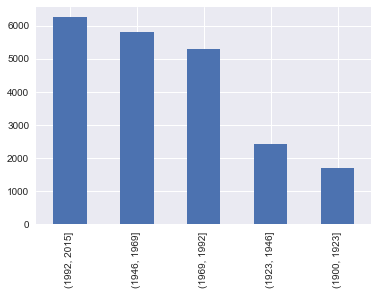

In [288]:
# first, create bins for based on the values observed. 5 values will result in 4 bins
bins = [1900, 1923, 1946, 1969, 1992, 2015]
# use pd.cut to create variable to store bins
bins_year = pd.cut(df['yr_built'], bins)
# using pd.cut returns unordered categories. Transform this to ordered categories.
bins_year = bins_year.cat.as_unordered()
bins_year.head()
# inspect the result
bins_year.value_counts().plot(kind='bar');
# replace the existing "yr_built" column
df["yr_built"]=bins_year

#### ['zipcode']

In [306]:
# In the summary below we see there are 70 different zipcode values possible. 
df['zipcode'].value_counts()

98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

In [307]:
# Recast zipcode as a category
df['zipcode'] = df['zipcode'].astype('category')

Text(0, 0.5, 'Frequency')

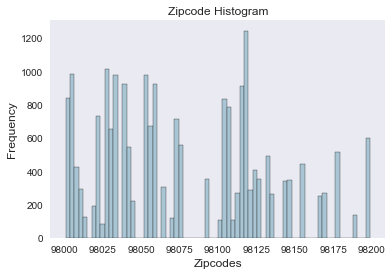

In [308]:
# Let's look at the data distribution of zipcode values 

fig, ax = plt.subplots()
df['zipcode'].hist(bins=70, color='#A9C5D3',
edgecolor='black', grid=False)
ax.set_title('Zipcode Histogram', fontsize=12)
ax.set_xlabel('Zipcodes', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [309]:
# Let’s define a binning scheme with custom ranges for the zipcode values 

# The bins will be created based on quantiles

quantile_list = [0, .25, .5, .75, 1.]

quantiles = df['zipcode'].quantile(quantile_list)

quantiles # 98001, 98033, 98065, 98118, 98199

0.00    98001.0
0.25    98033.0
0.50    98065.0
0.75    98118.0
1.00    98199.0
Name: zipcode, dtype: float64

In [310]:
# Now we can label the bins for each value and store both the bin range 
# and its corresponding label.

bin_ranges = [98000, 98033, 98065, 98118, 98200]

bin_names = [1, 2, 3, 4]

df['zc_range'] = pd.cut(df['zipcode'], bins=bin_ranges)

df['zc_label'] = pd.cut(df['zipcode'], bins=bin_ranges, labels=bin_names)

# view the binned features 
df[['zipcode','zc_range', 'zc_label']].iloc[9000:9005]

,zipcode,zc_range,zc_label
9000,98092,"(98065, 98118]",3
9001,98117,"(98065, 98118]",3
9002,98144,"(98118, 98200]",4
9003,98038,"(98033, 98065]",2
9004,98004,"(98000, 98033]",1


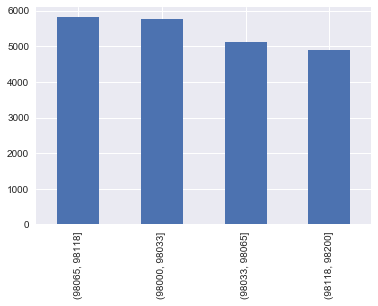

In [311]:
df.zc_range.value_counts().plot(kind='bar');

Text(0, 0.5, 'Frequency')

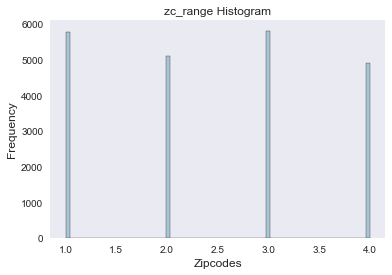

In [312]:
# Let's look at the data distribution of zc_label values 

fig, ax = plt.subplots()
df['zc_label'].hist(bins=70, color='#A9C5D3',
edgecolor='black', grid=False)
ax.set_title('zc_range Histogram', fontsize=12)
ax.set_xlabel('Zipcodes', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

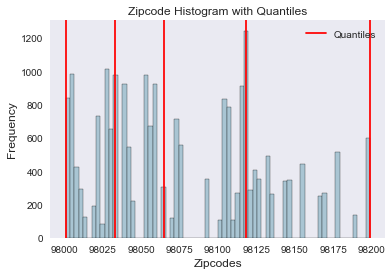

In [313]:
#Let’s now visualize these quantiles in the original distribution histogram!

fig, ax = plt.subplots()

df['zipcode'].hist(bins=70, color='#A9C5D3', edgecolor='black', grid=False)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color='r')
    ax.legend([qvl], ['Quantiles'], fontsize=10)
    ax.set_title('Zipcode Histogram with Quantiles',fontsize=12)
    ax.set_xlabel('Zipcodes', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)


#### ['condition']

In [ ]:
# Recast zipcode as a category
df['condition'] = df['condition'].astype('category')

In [ ]:
# BINARIZATION

# watched = np.array(popsong_df['listen_count']) 
# watched[watched >= 1] = 1
# popsong_df['watched'] = watched

#### ['grade']
#### ['floors']

#### ['bathrooms']
#### ['bedrooms']

In [143]:
#change the datatype of categorical features
df["yr_built"] = df["yr_built"].cat.codes
df["zc_range"] = df["zc_range"].cat.codes

#create dummy columns to store cat.codes
zipcode_dummy = pd.get_dummies(bins_zip, prefix="zip")
year_dummy = pd.get_dummies(bins_year, prefix="yr")

#drop now obsolete columns
df = df.drop(["yr_built","zipcode"], axis=1)

df = pd.concat([df, zipcode_dummy, year_dummy], axis=1)

#double check that everything is as it should be


array([98178, 98125, 98028, ..., 98144, 98027, 98144])

In [19]:
# Recast 'condition' as a category:
condition_series = df['condition']
cat_condition = condition_series.astype('category')

# get_dummies
pd.get_dummies(cat_condition)

# LabelBinarizer
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
condition_dummies = lb.fit_transform(cat_condition)

# Convert back to dataframe
condition_dum_df = pd.DataFrame(condition_dummies, columns=lb.classes_)

# Avoid Multicollinearity Trap
# One can be predicted based on others unless we drop one of the dummy cols:
pd.get_dummies(cat_condition, drop_first=True)
condition_dum_df.head(3)

,1,2,3,4,5
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0


In [ ]:
# Remove category columns and replace with dummy cols:

# Create Dummies
grade_dummies = pd.get_dummies(df['grade'], prefix='grade', drop_first=True)
condition_dummies = pd.get_dummies(df['condition'], prefix='condition', drop_first=True)
floors_dummies = pd.get_dummies(df['floors'], prefix='floors', drop_first=True)

# Remove original columns


# Add dummy columns 


In [ ]:
# Recast appropriate columns as category
df['zipcode'] = df['zipcode'].astype('category')
# Recast condition as a category
df['condition'] = df['condition'].astype('category')
# Recast grade as a category
df['grade'] = df['grade'].astype('category')

In [ ]:
df['bedrooms'].unique()
#array([ 3,  2,  4,  5,  1,  6,  7,  8,  9, 11, 10, 33])

df['bathrooms'].unique()
 # array([1.  , 2.25, 3.  , 2.  , 4.5 , 1.5 , 2.5 , 1.75, 2.75, 3.25, 4.  ,
   #    3.5 , 0.75, 4.75, 5.  , 4.25, 3.75, 1.25, 5.25, 6.  , 0.5 , 5.5 ,
   #    6.75, 5.75, 8.  , 7.5 , 7.75, 6.25, 6.5 ])
    
# Floors:
"""
1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
"""

### Continuous

* SQUARE-FOOTAGE

Redundancy check: is there any overlap in the measurements?

* sqft_living = sqft_basement + sqft_above ?
* sqft_lot - sqft_living = sqft_above ?



**Continuous Variables:**
a continuous variable can take on any value within a range

* **sqft_living** --> highest corr : price (before transformation/scaling); most normal distribution
* sqft_lot --> not normal distribution
* sqft_living15 #Highly skewed
* sqft_lot15 #Highly skewed
* sqft_above #High corr with sqft_living
* sqft_basement #Very high number of null values --> treat '0' = no basement?

## Multicollinearity
Heatmap: Absolute Correlation Matrix

##### Scrub 3: Multicollinearity

**Q3: which predictors are closely related (and should be dropped)?**
    + multicollinearity: one-hot dummy variables, data dropping
    + remove variable having most corr with largest # of variables

        * Checking for Multicollinearity
        * use seaborn to make correlation matrix plot
        * threshold >= 0.5 corr (rank correlations -- build custom function?) 
        * one-hot dummy variables, and data dropping


In [ ]:
corr = df.corr()

plt.figure(figsize=(20,20))
sns.heatmap(data=corr.abs(), annot=True, cmap=sns.color_palette('Blues'))
plt.show()

In [ ]:
# Subset dataframe into groups for easier viewing of data via individual subplots?

pd.plotting.scatter_matrix(df, figsize=(20,20));

In [ ]:
def plot_reg(data, feature, target):
    sns.regplot(x=feature, y=target, data=data)
    plt.show()

In [ ]:
plot_reg(df, 'sqft_living', 'price')
plot_reg(df, 'grade', 'price')
plot_reg(df, 'condition', 'price')
plot_reg(df, 'zipcode', 'price')

In [31]:
# Quick correlation check with the target (price) indicates none of the columns addressed above will be useful predictors (all have correlation coefficients below 0.5)
print(df['view'].corr(df['price']))
print(df['sqft_basement'].corr(df['price']))
print(df['waterfront'].corr(df['price']))
print(df['is_renovated'].corr(df['price']))

0.3934966693793815
0.32110756975956506
0.2643062804831158
0.11754308700194353


In [ ]:
# create variables for each seris you want to pass into the xcols list and compare them against one
y_sub = 'sqft_living'
sqft_sub = ['sqft_living15','sqft_above', 'sqft_lot', 'sqft_lot15']

def sub_scatter(xcols, y):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
    for xcol, ax in zip(xcols, axes):
        df.plot(kind='scatter', x=xcol, y=y, ax=ax, alpha=0.7, color='b')

In [ ]:
sub_scatter(sqft_sub, y_sub)

In [ ]:
# bathrooms: 
# sqft_living: 0.76
    # sqft_above: 0.69
    # grade: 0.67
    # sqft_living15: 0.57
# bedrooms: 0.51
    # yr_built: 0.51
# floors: 0.5
y_sub = 'price'
rm_sub = ['grade','condition', 'yr_built', 'view']

sub_scatter(rm_sub, y_sub)

In [ ]:
# bathrooms: 
# sqft_living: 0.76
    # sqft_above: 0.69
    # grade: 0.67
    # sqft_living15: 0.57
# bedrooms: 0.51
    # yr_built: 0.51
# floors: 0.5
y_sub = 'sqft_living'
rm_sub = ['bedrooms','bathrooms', 'floors', 'grade']

sub_scatter(rm_sub, y_sub)

In [ ]:
df['yr_renovated'].unique
df['yr_renovated'].value_counts()
df['yr_renovated'].isna().sum()
df['yr_renovated'].describe()
#RECAST AS CATEGORY
cat_yr_renov = df['yr_renovated'].astype('category')

In [ ]:
cat_yr_renov.cat.codes

In [ ]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
yr_renov_coded = lb_make.fit_transform(cat_yr_renov)

In [ ]:
yr_renov_coded

In [ ]:
# sqft_living, zipcode, and condition

check_column(df['yr_renovated'])



In [ ]:
# Check columns returns the datatype, null values and unique values of input series 
def check_column(series_feature, series_target=None):#,max_unique=10):
    """Takes a series from a dataframe (df[col]), 
    reports back info on unique values, nulls, .describe() stats.
    
    
    Args:
        series (series (DataFrame column)): column to report    
    """
    dashes = '---'*25
    series=series_feature
    
    
    
    print(f'Unique Values for {series.name}')
    print(dashes)
    print(f"series dtype is {series.dtype}\n")
    
    #Value Counts
    display(series.value_counts())#[:max_unique])
    print(dashes)
 
    print('\n\tDescribe')
    print(series.describe())
    
    if series.dtype != 'object':
        sns.distplot(series)
        plt.show()
    else:
        print(f"{series.name} is a string column and cannot be plotted")

    if series_target is not None:
        
        # Add your scatterplot here
        df.hist(figsize=(20,20));

In [ ]:
check_column(df['sqft_living'], series_target=df['price'])

In [ ]:
# MULTIPLOT
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def multiplot(df):

    sns.set(style="white")

    # Compute the correlation matrix
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(16, 16))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, center=0,
                
    square=True, linewidths=.5, cbar_kws={"shrink": .5}) #
    
# multiplot(df)

In [ ]:
# Pos Corr with Target (Price):
    # sqft_living: 0.7
        # grade: 0.67
        # sqft_above: 0.61
        # sqft_living15: 0.59
        # bathrooms: 0.53 

In [ ]:
# Multicollinearity

# bathrooms: 
    # sqft_living: 0.76
    # sqft_above: 0.69
    # grade: 0.67
    # sqft_living15: 0.57
    # bedrooms: 0.51
    # yr_built: 0.51
    # floors: 0.5

# sqft_living:
    # sqft_above: 0.88
    # sqft_living15: 0.76
    # grade: 0.76
    # bathrooms: 0.76
    # bedrooms: 0.58

# Grade
    #sqft_living: 0.76
    #sqft_above:  0.76
    #sqft_living15: 0.71
    #bathrooms: 0.67

# sqft_above: 
    # sqft_living: 0.88
    # sqft_living15: 0.73
    # floors: 0.52
    # grade: 0.76
        

In [ ]:
fig = plot_hist_scat(df)

## Drop columns

In [ ]:
#create copy of dataframe for dropped variables 
drop_cols =['id','lat','long','date']
dropped_df = df[drop_cols].copy()
# set id as index to match original df
dropped_df.set_index('id')
# safely drop the desired columns from orig dataset using: 
# df.drop(['col1','col2'],axis=1)
df.drop(drop_cols,axis=1,inplace=True)

# EXPLORE:
    Check distributions, outliers, etc
[ ] Check scales, ranges (df.describe())
[x] Check histograms to get an idea of distributions (df.hist()) and dat transformations to perform
Can also do kernel density estimates
[x] Use scatterplots to check for linearity and possible categorical variables (df.plot(kind-'scatter')
categoricals will look like vertical lines
[x] Use pd.plotting.scatter_matrix to visualize possible relationships
[x] Check for linearity

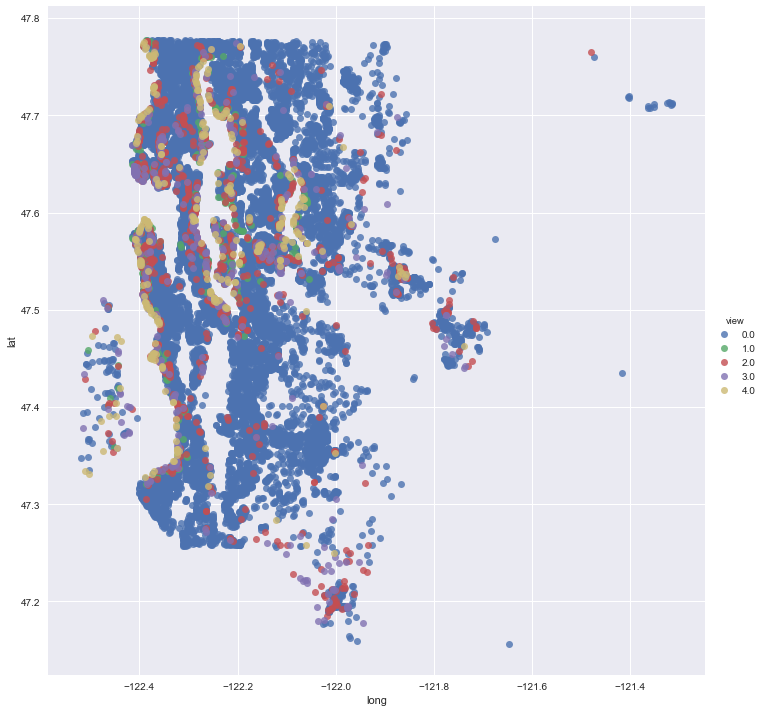

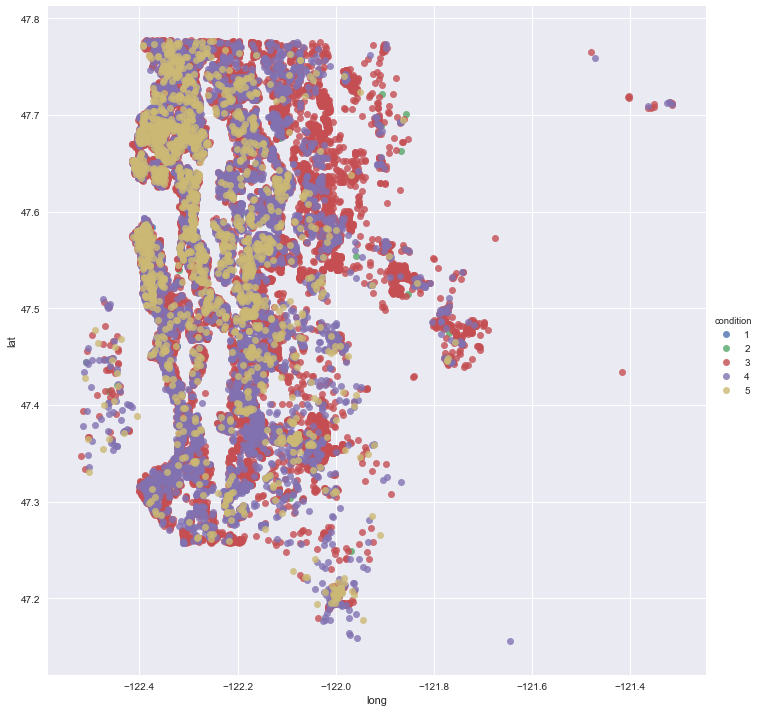

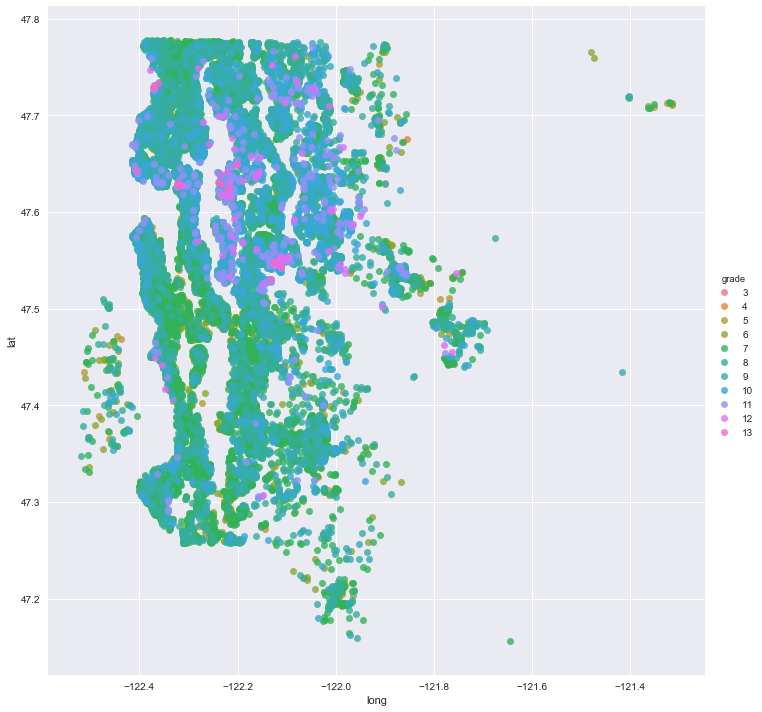

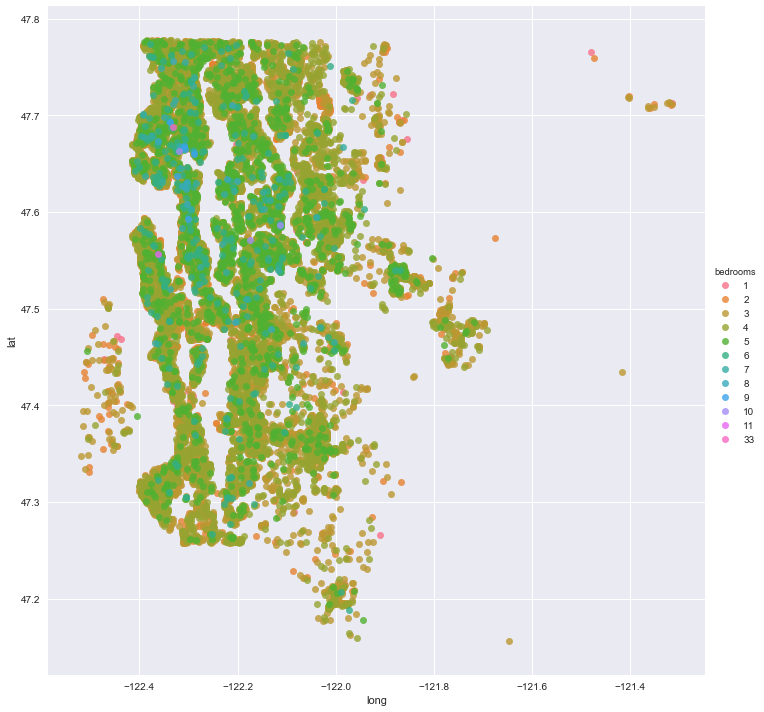

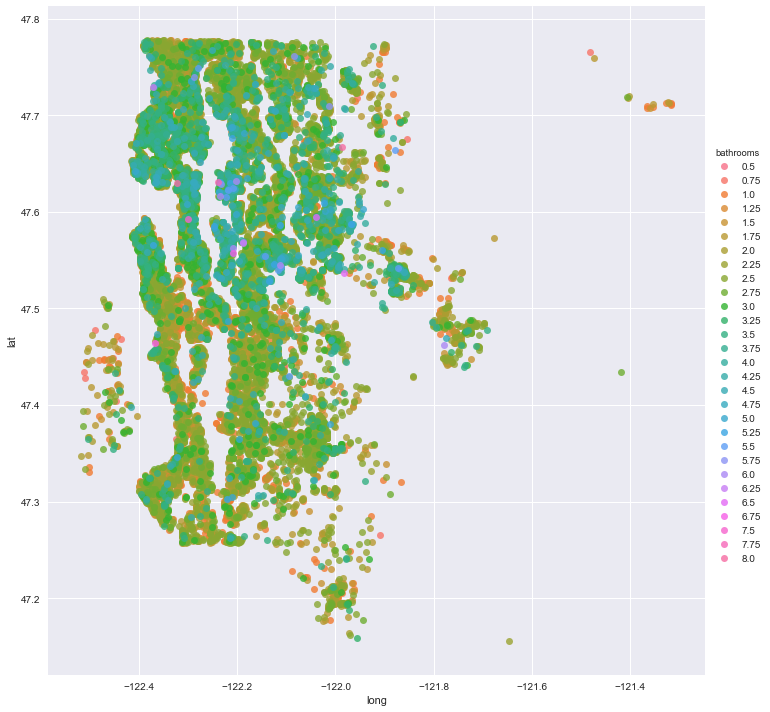

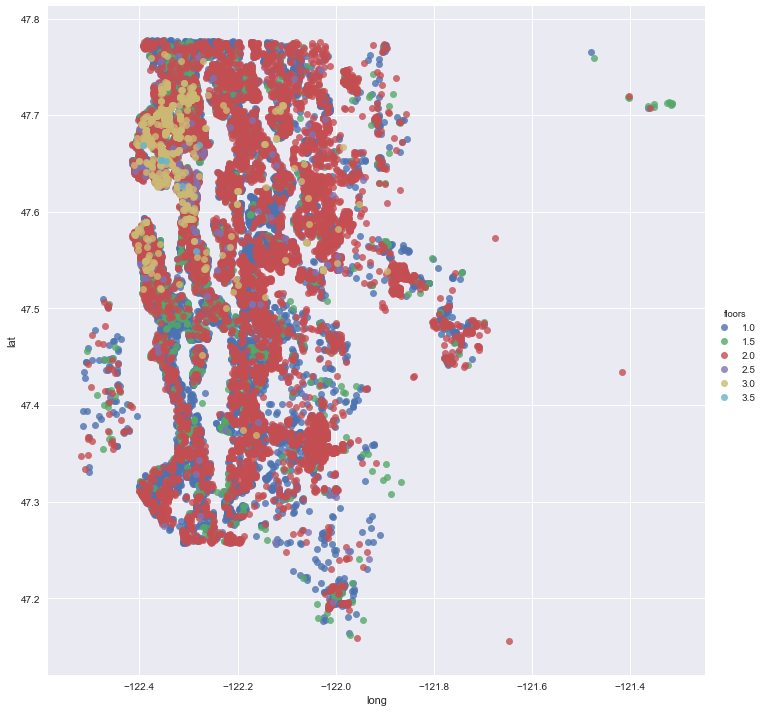

In [317]:
ord_features = ["view", "condition",
                  "grade","bedrooms", 
                 "bathrooms", "floors"]
#run the features through lmplot as a forloop to build graph
for x in ord_features:
    sns.lmplot(data=df, x="long", y="lat", fit_reg=False, hue=x, height=10)
plt.show()

In [ ]:
# check data discrepancies between duplicates (if any):

# 1 - compare price (house value) and date of sale:

# dupes         date        price
# 6021501535   12/23/2014   700,000
#               7/25/2014   430,000
    
# 4139480200   12/9/2014
# 7520000520   3/11/2015
# 3969300030   12/29/2014
# 2231500030   3/24/2015



for df['id'] in df:
    if df['id'] == 
        print(f"{df.id} : {date} : {price}\n")
     #  4139480200
#dupes_id = dupes['id']
#dupes_price = dupes['price']

# 2 - compare other discrepancies and/or missing values 

In [322]:
colormap = ('skyblue', 'salmon', 'lightgreen')
plt.figure()
pd.plotting.parallel_coordinates(df, 'price', 'sqft_living' color=colormap);

pd.plotting.scatter_matrix(df);

SyntaxError: invalid syntax (<ipython-input-322-ccbe26b7c1a3>, line 3)

## DATE

In [ ]:
# group data by dates/months/years to explore comparison in market fluctuations

print(df.date.min())
print(df.date.max())

# Our dataset contains values spanning two years: beginning May 2014 to end of May 2015

In [ ]:
df.date.dt.year.value_counts(normalize=True)
# 2014    14622
# 2015     6975
# The majority of our data (67%) is from 2014

In [ ]:
df.date.dt.month.value_counts()

### Impact of date (month or year) on price
Question: are housing prices lower or higher in certain months (better to buy)?

In [ ]:
# create new columns for year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [ ]:
# There does not appear to be any correlation whatsoever with 
weights = np.linspace(0,1)
np.corrcoef(df['month'], df['price'])
np.corrcoef(df['year'], df['price'])

In [ ]:
df.month.value_counts(normalize=True)

In [ ]:
# create variables for each series you want to pass into the xcols list and compare them against one
y_sub = 'price'
date_sub = ['year','month']

def sub_scatter(xcols, y):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,3))
    for xcol, ax in zip(xcols, axes):
        df.plot(kind='scatter', x=xcol, y=y, ax=ax, alpha=0.7, color='b')

sub_scatter(date_sub, y_sub)

In [ ]:
# 1
# Visualize linearity with a pairplot (seaborn)
# Attempt to add a line of best fit and 95% confidence band. Aim to minimize sum of squared error.

#sns.pairplot(df, X, y, kind='reg')

def pairplot_loop(df=df, y='price', reg=True):
    for col in df:
        #col_corr = col.corr().abs()
        sns.pairplot(df, col, y, kind='reg')
        #if col_corr > 0.5:
            #print('Correlation coefficient is: {0}'.format(col_corr))
pairplot_loop(df, df.columns, y='price', reg=True)            
# sns.pairplot(df, X, y, kind='reg')

In [ ]:
#SEABORN
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

# Plots histogram and scatter (vs price) side by side
def plot_hist_scat_sns(df,target='price'):
    #plt.style.use('dark_background')

    
    ## ----------- DEFINE AESTHETIC CUSTOMIZATIONS ----------- ##
    # Axis Label fonts
    fontTitle = {'fontsize': 16,
               'fontweight': 'bold',
                'fontfamily':'serif'}

    fontAxis = {'fontsize': 14,
               'fontweight': 'bold',
                'fontfamily':'serif'}

    fontTicks = {'fontsize': 12,
               'fontweight':'bold',
                'fontfamily':'serif'}

    # Formatting dollar sign labels
    fmtPrice = '${x:,.0f}'
    tickPrice = mtick.StrMethodFormatter(fmtPrice)
    

    ## ----------- PLOTTING ----------- ##
    
    ## Loop through dataframe to plot
    for column in df.describe():
    
        # Create figure with subplots for current column
        # Note: in order to use identical syntax for large # of subplots (ax[i,j]), 
        #  declare an extra row of subplots to be removed later
        fig, ax = plt.subplots(figsize=(12,10), ncols=2, nrows=2)

        ## ----- SUBPLOT 1 -----##
        i,j = 0,0
        ax[i,j].set_title(column.capitalize(),fontdict=fontTitle)
        
        # Define graphing keyword dictionaries for distplot (Subplot 1)
        hist_kws = {"linewidth": 1, "alpha": 1, "color": 'blue','edgecolor':'w'}
        kde_kws = {"color": "white", "linewidth": 1, "label": "KDE"}
        
        # Plot distplot on ax[i,j] using hist_kws and kde_kws
        sns.distplot(df[column], norm_hist=True, kde=True,
                     hist_kws = hist_kws, kde_kws = kde_kws,
                     label=column+' histogram', ax=ax[i,j])
 

        # Set x axis label
        ax[i,j].set_xlabel(column.title(),fontdict=fontAxis)
    
        # Get x-ticks, rotate labels, and return
        xticklab1 = ax[i,j].get_xticklabels(which = 'both')
        ax[i,j].set_xticklabels(labels=xticklab1, fontdict=fontTicks, rotation=45)
        ax[i,j].xaxis.set_major_formatter(mtick.ScalarFormatter())

        
        # Set y-label 
        ax[i,j].set_ylabel('Density',fontdict=fontAxis)
        yticklab1=ax[i,j].get_yticklabels(which='both')
        ax[i,j].set_yticklabels(labels=yticklab1,fontdict=fontTicks)
        ax[i,j].yaxis.set_major_formatter(mtick.ScalarFormatter())
        
        
        # Set y-grid
        ax[i, j].set_axisbelow(True)
        ax[i, j].grid(axis='y',ls='--')

        
        ## ----- SUBPLOT 2-----  ##
        i,j = 0,1
        ax[i,j].set_title(column.capitalize(),fontdict=fontTitle)

        # Define the ketword dictionaries for  scatter plot and regression line (subplot 2)
        line_kws={"color":"white","alpha":0.5,"lw":4,"ls":":"}
        scatter_kws={'s': 2, 'alpha': 0.5,'marker':'.','color':'blue'}

        # Plot regplot on ax[i,j] using line_kws and scatter_kws
        sns.regplot(df[column], df[target], 
                    line_kws = line_kws,
                    scatter_kws = scatter_kws,
                    ax=ax[i,j])
        
        # Set x-axis label
        ax[i,j].set_xlabel(column.title(),fontdict=fontAxis)

         # Get x ticks, rotate labels, and return
        xticklab2=ax[i,j].get_xticklabels(which='both')
        ax[i,j].set_xticklabels(labels=xticklab2,fontdict=fontTicks, rotation=45)
        ax[i,j].xaxis.set_major_formatter(mtick.ScalarFormatter())

        # Set  y-axis label
        ax[i,j].set_ylabel('Price',fontdict=fontAxis)
        
        # Get, set, and format y-axis Price labels
        yticklab = ax[i,j].get_yticklabels()
        ax[i,j].set_yticklabels(yticklab,fontdict=fontTicks)
        ax[i,j].get_yaxis().set_major_formatter(tickPrice) 

        # Set y-grid
        ax[i, j].set_axisbelow(True)
        ax[i, j].grid(axis='y',ls='--')       
        
        ## ---------- Final layout adjustments ----------- ##
        # Deleted unused subplots 
        fig.delaxes(ax[1,1])
        fig.delaxes(ax[1,0])

        # Optimizing spatial layout
        fig.tight_layout()
        figtitle=column+'_dist_regr_plots.png'
        #plt.savefig(fig_filepath+figtitle)
    return

In [ ]:
# Side by side plot of Histograms and Scatterplots for each variable vs price:

fig = plot_hist_scat_sns(df,target='price')

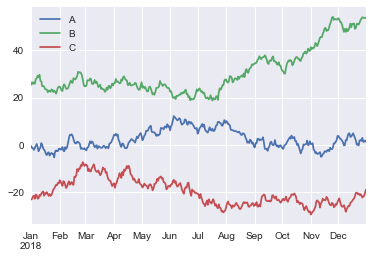

In [323]:
# TIME-SERIES DATA SET
# set a random seed for controlling randomization

import pandas as pd
import numpy as np

np.random.seed(777)
data = pd.DataFrame({'A': np.random.randn(365).cumsum(),
                     'B': np.random.randn(365).cumsum() +25,
                     'C': np.random.randn(365).cumsum() -25 },
                        index = pd.date_range('1/1/2018', periods=365))
data.plot()
                    

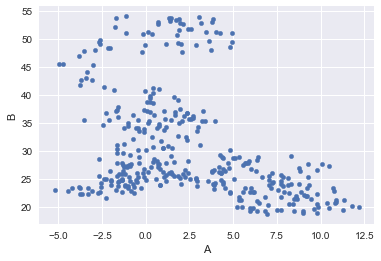

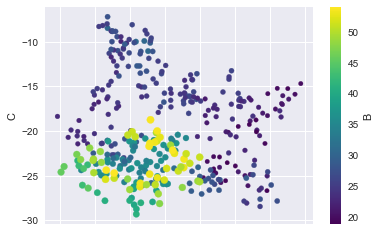

In [324]:
data.plot('A','B', kind='scatter');
# A and C columns plotted with graduating color and changing size based on values in the B column. 
data.plot.scatter('A', 'C',
                   c = 'B',
                   s = data['B'],
                   colormap='viridis');

In [ ]:
sns.lmplot(x='feature1', y='target', hue='feature2', data=df)
sns.lmplot(col='time', row='sex', x='feature1', y='target', hue='feature2', data=df)

## Outliers

In [ ]:
# Tukey's method using IQR to eliminate 
def detect_outliers(df, n, features):
    outlier_indices = []
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        # select observations containing more than 2 outliers
        outlier_indices = Counter(outlier_indices)        
        multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
        return multiple_outliers 
# Outliers_to_drop = detect_outliers(data,2,["col1","col2"])
# df.loc[Outliers_to_drop] # Show the outliers rows
# Drop outliers
# data= data.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [ ]:
features = df.columns
#['condition', 'grade','zipcode','sqft_living', 'bathrooms']
outliers_to_drop = detect_outliers(df, 2, features)
df.loc[outliers_to_drop]


In [ ]:
outliers_to_drop

# FIT AN INITIAL MODEL:
Various forms, detail later...
Assessing the model:
Assess parameters (slope,intercept)
Check if the model explains the variation in the data (RMSE, F, R_square)
Are the coeffs, slopes, intercepts in appropriate units?
Whats the impact of collinearity? Can we ignore?
Revise the fitted model
Multicollinearity is big issue for lin regression and cannot fully remove it
Use the predictive ability of model to test it (like R2 and RMSE)
Check for missed non-linearity
Holdout validation / Train/test split
use sklearn train_test_split

In [ ]:
# Plots histogram and scatter (vs price) side by side
def plot_hist_scat(df,target='price',stats=False):
#     plt.style.use('bmh')
    plt.style.use('fivethirtyeight')
    
#     fontTitle = {'family': 'serif',
#             'color':  'black',
#             'weight': 'normal',
#             'size': 16,
#             }
#     fontTicks = {'family': 'sans-serif',
#             'color':  'black',
#             'weight': 'normal',
#             'size': 10,
#             }
    results = [['column','K_square','p-val']]

    for column in df.describe():

        fig = plt.figure(figsize=(8,3) )#plt.figaspect(0.5))#(5,4))
        
        ax1 = fig.add_subplot(121)
        ax1.hist(df[column],density=True,label = column+' histogram',bins=20)
        ax1.set_title(column.capitalize())

        ax1.legend()
        
        ax2 = fig.add_subplot(122)
        ax2.scatter(x=df[column], y=df[target],label = column+' vs price',marker='.')
        ax2.set_title(column.capitalize())
        ax2.legend()

        fig.tight_layout()
        if stats==True:
            stat, p = normtest(df[column])
#             print(f'Normality test for {column}:K_square = {stat}, p-value = {p}')

            results.append([column,stat, p])
    return pd.DataFrame(results)

In [ ]:
# 2
# SK Learn - X is a feature matrix in Pandas Dataframe.
# Y is a response vector (Pandas series)
# Separate variables

feature_cols = ['sqft_living','condition','zipcode']
X = df[feature_cols]
y = df['price']

In [ ]:
# 3
# Splitting X & y into training and testing sets
# By passing X and y variables into the train_test_split method,
# we can capture the splits in data by assigning 4 variables to the result:

# Import SK Learn train test split
import sklearn
from sklearn.cross_validation import train_test_split

# Assign variables to capture train test split output
X_train, X_test, y_train, y_test = train_test_split(X, y)



In [ ]:
# 4 Train the model

# Import sklearn.linear_model to access LinearRegression 
from sklearn.linear_model import LinearRegression

# instantiate and model fit to training data
linreg = LinearRegression()

# fit model to training data (learn coefficients)
linreg.fit(X_train, y_train)

In [ ]:
# 5
# Interpreting Coefficients
# The coefficients will allow us to model our equation with values for our beta's. 
# The linreg variable (assigned to a LinearRegression object) extracts the intercept and coefficients

# Print y-intercept
print(linreg.intercept_)

# Print beta coefficients in same order as passed
print(linreg.coef_)

# Pair the feature names and coeffiecients together
zip(feature_cols, linreg.coef_)

# The intercept is the B0 value; 
# Each coef is corresponding Beta for the X's passed in, respective order


In [ ]:
# 6 
# Making predictions based on the model:
# Pass the predict method to test data
# Return prediced values of y given new test X data

y_pred = linreg.predict(X_test)

In [ ]:
# 7 
# Primary metrics for evaluating linear models:
# Mean absolute error (MAE) : easiest to understand, represents average error
# Mean Squared Error (MSE) : similar to MAE but noise is exaggerated and larger errors are "punished"
# Root mean squared error (RMSE) : similar to MSE but easier to interpret bc uses base units. Primary metric*

# Each of the above requires two lists as parameters: predicted values and true values

# Import metrics library
from sklearn import metrics

# Print result of MAE:
print(metrics.mean_absolute_error(y_test, y_pred))

# Print resultof MSE:
print(metrics.mean_squared_error(y_true, y_pred))

# Print result of RMSE:
print(np.sqrt(metrics.mean_squared_error(y_true, y_pred)))


In [ ]:
# 8
# Feature Selection
# Note which X's have minimal impact on y. Remove these to make model more accurate

# Replace feature_cols & X
# Train_test_split data
# Fit model to linreg again using linreg.fit
# Make predictions using (y_pred = linreg.predict(X_test))
# Compute RMSE
# Repeat until RMSE satisfactory

In [ ]:
# Choose a linear model by forward selection
# The function below optimizes adjusted R-squared by adding features that help the most one at a time
# until the score goes down or you run out of features.

import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [ ]:
model = forward_selected(df, 'price')
print(model.model.formula)
print(model.rsquared_adj)


Explaining/Phrasing R-Squared values
An obtained R-squared value of say 0.85 can be put into a statement as

85% of the variations in dependent variable  𝑦  are explained by the independent variable in our model.

# Visualizations

##### TABLEAU HOW TO (temp)
Short how-to plot geo data in Tableau:
Load in your .csv dataset from your project.
Let it use data interpreter. It should identify zipcode as a location.
On your worksheet page:
For plotting each price for each house:
Drag the Measures Lat and Long onto the rows and columns boxes (top of sheet)
Drag the Measure price onto the Color Button under Marks.
It should now be listed at the bottom of the Marks panel.
Right-click and select "Dimension"
For plotting median income by zipcode:
Drag zipcode form the Dimensions panel onto the main graph window.
It will automatically load in map of location.
Drag price onto the color button (it will now appear in the Marks window)
Rich click on Price. Select "Measure" > Median
Customize map features by selecting "Map" > Map Layers on the Menu Bar.


In [ ]:
# https://www.youtube.com/watch?v=upBvuTqOy9k&feature=youtu.be

import plotly
plotly.offline.init_notebook_mode(connected=True)

import pandas as pd
import numpy as np

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

In [ ]:
data = go.Scatter(x=[1,2,3,4], y=[3,6,8,9], name='Blue')
layout = go.Layout(title='Random Scatter')

fig = go.Figure(data=data, layout=layout)

* "how did you pick the question(s) that you did?"
* "why are these questions important from a business perspective?"
* "how did you decide on the data cleaning options you performed?"
* "why did you choose a given method or library?"
* "why did you select those visualizations and what did you learn from each of them?"
* "why did you pick those features as predictors?"
* "how would you interpret the results?"
* "how confident are you in the predictive quality of the results?"
* "what are some of the things that could cause the results to be wrong?"